In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob 
#from astropy.visualization import quantity_support
#quantity_support()  # for getting units on the axes below  
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from termcolor import colored 
from multiprocessing import Pool
import warnings
from zipfile import ZipFile

In [4]:
#grab anything that contains '.fits'
files = glob('*.fits')
mcfiles = glob('*emcee.h5')

# sort mcfiles to the order files is in
mcfiles_sorted = [] # create empty list
# iterate through each value in files and if they start the same add it to the 
# new list so that mcfiles is ordered the same as files
for j in range(len(files)): 
    for i in range(len(mcfiles)):
        mcfilehead=mcfiles[i][:-9]
        if files[j]==mcfilehead:
            mcfiles_sorted.append(mcfiles[i])
            
# print('mcfiles not sorted:\n' + str(mcfiles))
# print('\nmcfiles sorted:\n' + str(mcfiles_sorted))
# print('\nfiles sorted:\n' + str(files))

In [9]:
def ssp(theta):
    """
    plots a stsynphot graph based on a theta that holds the values of t_eff, log_g, rv, ebv, radius
    """
    t_eff, log_g, rv, ebv, radius = theta # unpack theta
    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) # model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) # speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) # average of total/selective dimming
    
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2
    
    return reddenedmodel_flux

In [10]:
def fitsfile(i):
    """
    Opens fits file and prints which file it is
    """
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i) + ' and named ' + hdr['OBJECT'], 'red', attrs=['bold'])  
    #print(text)  
    #print(specdata)
    
    #print(spec1d)
    return spec1d, hdr
    

In [11]:
def smooth(i):
    """
    Smooths the data of file i so it is easier to fit the model to the data
    """
    spec1d, hdr = fitsfile(i)
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    return spec_interp, spec1d

In [12]:
def byeye(theta, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii) in theta
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array along with the smoothed data
    """

    reddenedmodel_flux = ssp(theta) # constructs stsynphot model based on theta
    spec_interp, spec1d = smooth(i)
    
    
    ax = plt.subplots()[1] 
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)
    plt.plot(wavelength, reddenedmodel_flux)
    plt.show
#     diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
#     print(diff)

In [34]:
def postpred(wavelength, i):
    """
    Takes an array of wavelength points and graph number i and 
    outputs corresponding emcee model flux evaluated on the wavelength array along with the smoothed data. 
    (posterior predictive plot)
    """
    # unpack values from smoothed data and loademcee
    spec_interp, spec1d = smooth(i)
    samples = loademcee(i) # unpack

    ax = plt.subplots(dpi=300)[1] 
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value, label='smoothed data', lw=2) # smooth
    ax.set_xlim(3000,9700)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)

    # plot emcee generated parameters within the given error bars 32 times
    rand_ind=np.random.randint(0,127999, size=32)
    label = 'emcee' #(wavelength, reddenedmodel_flux, alpha=1, label='emcee', color='black')
    for i in rand_ind: #choose random thetas
        theta = samples[i]
        reddenedmodel_flux = ssp(theta)
        plt.plot(wavelength, reddenedmodel_flux, alpha=.05, color='black', label=label)
        label = None
    
    
    plt.show
    ax.legend(loc='upper right')

In [29]:
def loademcee(i):
    """
    reads the h5 file and generates theta values where theta is [t_eff, log_g, rv, ebv, radius]
    """
    # load the file
    reader = emcee.backends.HDFBackend('/Users/kchen/FYPS/' + mcfiles_sorted[i])
    #discard first 1000 points where it's converging
    samples = reader.get_chain(flat=True, discard=1000)
    return samples

In [36]:
def cornerplot(i):
    """
    Plots corner plot for index i in the array of mcfiles_sorted
    """
    
    samples = loademcee(i)
    
    # give axes labels
    labels = ['t_eff', 'log_g', 'rv', 'ebv', 'radius']
    
    # plot
    fig = corner.corner(samples, labels=labels)
    axes = np.array(fig.axes).reshape(5,5)
    
    for ax in axes.flatten():
        # change size of axes
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        ax.title.set_size(16)
        # change size of ticks
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)

In [16]:
def trace(i):
    """
    Makes trace graph based on the emcee run in the index i of the 'mcfiles_sorted' array
    """
    samples = loademcee(i)
    fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
    nfsamples = reader.get_chain()
    labels = ["t_eff", "log_g", "rv", "ebv", "radius"]
    for i in range(5):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(nfsamples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

In [21]:
def mcvalues(i):
    """
    Prints emcee's guesses of parameters t_eff, log_g, rv, ebv, and radius with an error of 2 standard deviations
    for the index i of 'mcfiles_sorted'
    """
    labels = ['t_eff', 'log_g', 'rv', 'ebv', 'radius']
    samples = loademcee(i) # unpack
    for i in range(5):
        mcmc = np.percentile(samples[:,i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        print(txt)
    

In [37]:
# calculate mcvalues
mcvalues(3)

\mathrm{t_eff} = 4984.008_{-3.192}^{50.997}
\mathrm{log_g} = 0.835_{-0.040}^{0.007}
\mathrm{rv} = 99.869_{-0.260}^{0.099}
\mathrm{ebv} = 0.080_{-0.001}^{0.023}
\mathrm{radius} = 714.626_{-0.647}^{2.704}


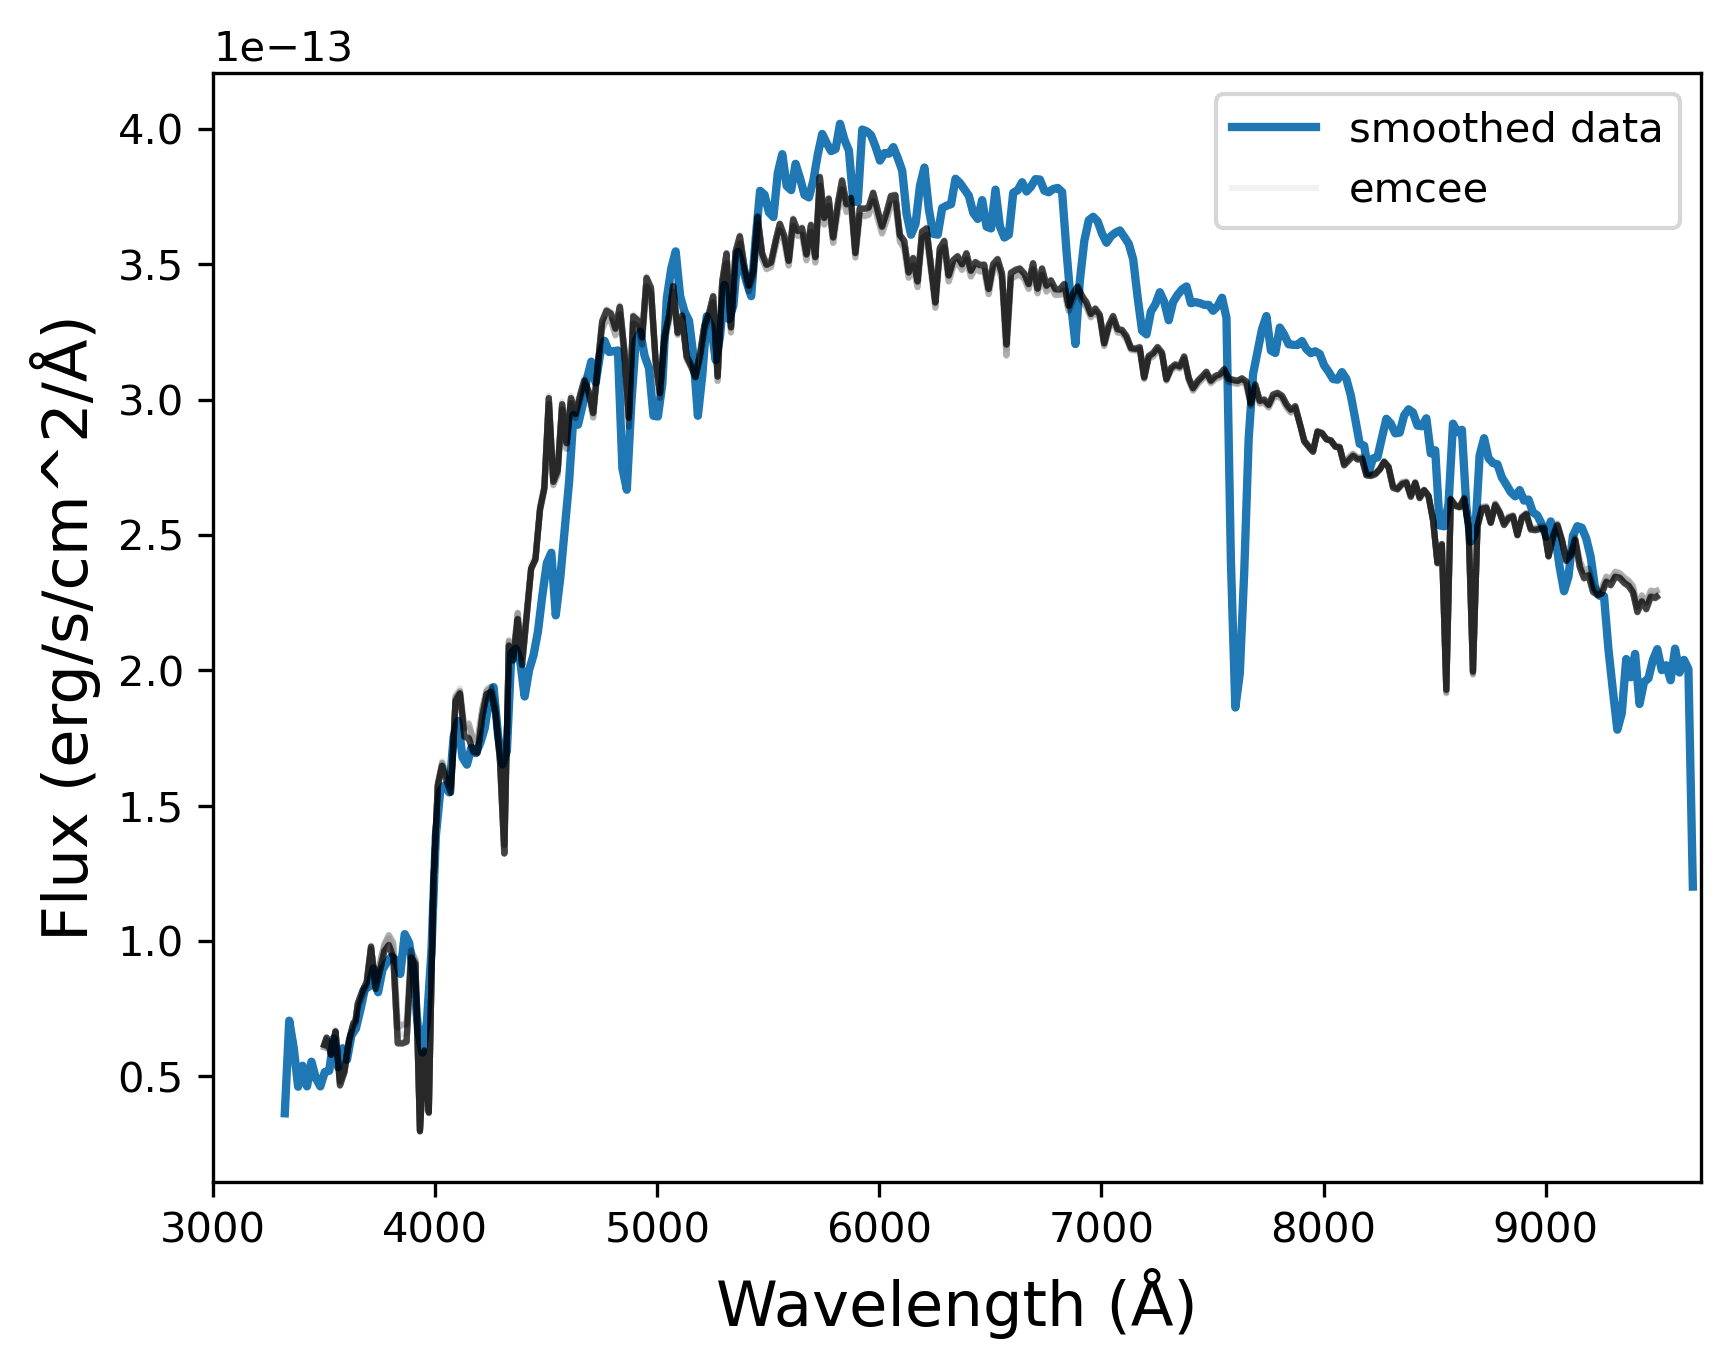

In [35]:
# plot a posterior predictive plot for index 3
wavelength = np.linspace(3500, 9500, 20000)
postpred(wavelength, 3)